In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

import os
#-----
from torch.utils.tensorboard import SummaryWriter

# Enable interactive plot

#%matplotlib notebook
plt.style.use('seaborn')

## Loading dataset

In [2]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, total_data = 200000, sequence_len = 5, transform=True):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.sequence_len = sequence_len
        self.total_data = total_data//sequence_len
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 200 data by file (from 0 to 199), 1000 files(from 0 to 999), total data: 200*100 = 200000
        
        if index > total_data:
            print("Error, this data does not exist")
        else:
            index_data = (index//40)%40  # because there 0-199=200 data per file / 5 = seq len 
            index_t = (index*self.sequence_len-200)%200
            
            X = np.empty((5,96), np.float32)
            
            for i in range(self.sequence_len):
                # Input data: Wavepacket real and imaginary part + Potential at time t
                x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t+i)+'-wave.npy')).real
                x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t+i)+'-wave.npy')).imag
                x_p = np.load(self.data+str(index_data)+'/Potential/'+str(index_t+i)+'-potential.npy')
                
                X[i] = np.concatenate((x_r, x_i, x_p))  # flat array form
                
                
            # Output data: Wavepacket real and imaginary part at time t+1*step
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).imag
        
            y = np.concatenate((y_r, y_i))  # flat array form
        
            if self.transform:
                X = torch.from_numpy(X)
                y = torch.from_numpy(y)
        
            return X, y#[None, :]
    
    def __len__(self):
        
        
        return self.total_data

In [3]:
path = '../../Data_Gaussian/data'  # Directory where are saving our data

dataset = Propagator_Dataset(data=path, targets=path, transform=True)

In [4]:
dataset_size = len(dataset)
print('Total of data ', dataset_size)

Total of data  40000


## Training and Validation data split

In [6]:
validation_split = .1  #9:1 ratio
shuffle_dataset = True
random_seed= 42

In [7]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)


# Creating PT data samplers and loaders: Sequential form:
#train_sampler = SequentialSampler(train_indices)
#test_sampler = SequentialSampler(val_indices)

In [8]:
print(f"Total of train samples: {len(train_sampler)}")
print(f"Total of test samples: {len(test_sampler)}")

Total of train samples: 36000
Total of test samples: 4000


In [9]:
batch_size = 16

In [10]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

## Shape of data

In [27]:
for X, y in train_loader:
    print("Train data:")
    print(f"Shape of X in train loader: {X.shape}")
    print(f"Shape of y in train loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Train data:
Shape of X in train loader: torch.Size([16, 5, 96])
Shape of y in train loader: torch.Size([16, 64])
Batch size: 16


## Visualization

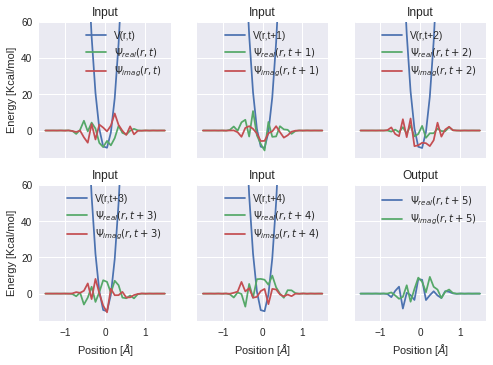

In [13]:
# Choose a random data
for X, y in train_loader:
    
    X_real_vis = X[0,0,0:32]
    X_real_vis1 = X[0,1,0:32]
    X_real_vis2 = X[0,2,0:32]
    X_real_vis3 = X[0,3,0:32]
    X_real_vis4 = X[0,4,0:32]
    
    X_imag_vis = X[0,0,32:64]
    X_imag_vis1 = X[0,1,32:64]
    X_imag_vis2 = X[0,2,32:64]
    X_imag_vis3 = X[0,3,32:64]
    X_imag_vis4 = X[0,4,32:64]
    
    X_pot_vis = X[0,0,64:96]
    X_pot_vis1 = X[0,1,64:96]
    X_pot_vis2 = X[0,2,64:96]
    X_pot_vis3 = X[0,3,64:96]
    X_pot_vis4 = X[0,4,64:96]
    
    
    
    y_real_vis = y[0,0:32]
    y_imag_vis = y[0,32:64]
    
    break

fig, axs = plt.subplots(2,3)
r_n = np.linspace(-1.5,1.5,32)

# Input: Sequence of lenght 5 fs
axs[0,0].plot(r_n, X_pot_vis*(1/1.5936e-3), "-", label="V(r,t)")
axs[0,0].plot(r_n, X_real_vis*10, label="$\Psi_{real}(r, t)$")
axs[0,0].plot(r_n, X_imag_vis*10, label="$\Psi_{imag}(r, t)$")
axs[0,0].set_title("Input")

axs[0,1].plot(r_n, X_pot_vis1*(1/1.5936e-3), "-", label="V(r,t+1)")
axs[0,1].plot(r_n, X_real_vis1*10, label="$\Psi_{real}(r, t+1)$")
axs[0,1].plot(r_n, X_imag_vis1*10, label="$\Psi_{imag}(r, t+1)$")
axs[0,1].set_title("Input")

axs[0,2].plot(r_n, X_pot_vis2*(1/1.5936e-3), "-", label="V(r,t+2)")
axs[0,2].plot(r_n, X_real_vis2*10, label="$\Psi_{real}(r, t+2)$")
axs[0,2].plot(r_n, X_imag_vis2*10, label="$\Psi_{imag}(r, t+2)$")
axs[0,2].set_title("Input")

axs[1,0].plot(r_n, X_pot_vis3*(1/1.5936e-3), "-", label="V(r,t+3)")
axs[1,0].plot(r_n, X_real_vis3*10, label="$\Psi_{real}(r, t+3)$")
axs[1,0].plot(r_n, X_imag_vis3*10, label="$\Psi_{imag}(r, t+3)$")
axs[1,0].set_title("Input")

axs[1,1].plot(r_n, X_pot_vis4*(1/1.5936e-3), "-", label="V(r,t+4)")
axs[1,1].plot(r_n, X_real_vis4*10, label="$\Psi_{real}(r, t+4)$")
axs[1,1].plot(r_n, X_imag_vis4*10, label="$\Psi_{imag}(r, t+4)$")
axs[1,1].set_title("Input")


# Output
axs[1,2].plot(r_n, y_real_vis*10, label="$\Psi_{real}(r, t+5)$")
axs[1,2].plot(r_n, y_imag_vis*10, label="$\Psi_{imag}(r, t+5)$")
axs[1,2].set_title("Output")



for axr1 in axs:
    for axr11 in axr1:
        axr11.set_ylim([-15, 60])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.show()
    


## LSTM model
___

In [14]:
device = 'cpu'

In [35]:
class LSTM(nn.Module):
    def __init__(self, num_output, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_output = num_output  # number of output
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1

        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(128, num_output) #fully connected last layer
    
    def forward(self,x):
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [36]:
input_size = 96  # number of features: 32 real part +32 complex part +32 potential
hidden_size = 2  # number of features in hidden state
num_layers = 1  # number of stacked lstm layers

num_output = 64  # number of output: 32 real part + 32 complex part
sequence_len = 5  # lenght of time steps (1 fs each one) toal 5 fs

learning_rate = 1e-4

In [37]:
model = LSTM(num_output, input_size, hidden_size, num_layers, sequence_len) #our lstm class

In [38]:
# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)



## Accuracy function

In [20]:
def S_overlap(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test
    Psi_ANN: Evolution of wavepacket predicted with the model
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article
    
    """
    S_tot = []
    angle_tot = []
    for j in range(batch_size):
        Psi_true_re = Psi_true[j,0:32]  # real part of wavepacket
        Psi_true_im = Psi_true[j,32:64]  # imaginary part of wavepacket
        Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    
        Psi_ANN_re = Psi_ANN[j,0:32]  # realpart of wavepacket predicted
        Psi_ANN_im = -Psi_ANN[j,32:64]  # imaginary part of wavepacket predicted (- because conjugate)
        Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
        
        
        
        overlap = []
        for i in range(32):
            overlap.append(torch.tensor([Psi_A[i]*Psi_t[i]]))
        overl = torch.tensor(overlap)
        
        # Integrate over r (real integral + complex integral)
        # Simpson method in the grid r_n (angstroms -> au)
        r_n = np.linspace(-1.5,1.5,32)*(1/0.5291775)
        overl_real = overl.real.numpy()
        overl_imag = overl.imag.numpy()
    
        real_integ = integrate.simpson(overl_real, r_n)
        imag_integ = integrate.simpson(overl_imag, r_n)
    
        # Covert to phase and magnitude of the complex result
        S_tot.append(np.sqrt(real_integ**2 + imag_integ**2))
        angle_tot.append(np.arctan(imag_integ/real_integ))
        
    S = sum(S_tot)/batch_size
    angle = sum(angle_tot)/batch_size
    
    return S, angle

In [21]:
# Test over test loader
correct1 = 0
for X, y in test_loader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    X, y = X.to(device), y.to(device)
    S, angle = S_overlap(y, y)  # Accuracy by equation (11) Main Article       
    correct1 += S
correct1 /= len(test_loader)
print(f"Test Error: \n Accuracy: {(100*correct1):>0.1f}%\n")  # Should be 100% because y=y => main of |S| = 1

Test Error: 
 Accuracy: 100.0%



In [39]:
writer = SummaryWriter('LSTM_0-model')  # To use tensorboard

In [41]:
for X,y in train_loader:
    writer.add_graph(model,X)
    break

## Train & Test loop definition

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)#len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            writer.add_scalar("Loss/train", loss, epoch)


In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y, pred)  
            correctS += S
            correct_phase += angle
    test_loss /= num_batches
    correctS /= num_batches
    correct_phase /= num_batches
    writer.add_scalar('Accuracy Magnitude |S| /test', 100*correctS, epoch)  # Should be 100%
    writer.add_scalar('Accuracy phase /test', correct_phase, epoch)  # Should be 0
    

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

## Training

In [25]:
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(test_loader, model, criterion)
    
writer.flush()

Epoch 1
-------------------------------
loss: 0.123176  [    0/ 2250]
loss: 0.088819  [ 1600/ 2250]
loss: 0.084746  [ 3200/ 2250]
loss: 0.085359  [ 4800/ 2250]
loss: 0.085711  [ 6400/ 2250]
loss: 0.084767  [ 8000/ 2250]
loss: 0.085441  [ 9600/ 2250]
loss: 0.084771  [11200/ 2250]
loss: 0.084947  [12800/ 2250]
loss: 0.085409  [14400/ 2250]
loss: 0.084990  [16000/ 2250]
loss: 0.085099  [17600/ 2250]
loss: 0.082092  [19200/ 2250]
loss: 0.084514  [20800/ 2250]
loss: 0.082924  [22400/ 2250]
loss: 0.081980  [24000/ 2250]
loss: 0.082976  [25600/ 2250]
loss: 0.077690  [27200/ 2250]
loss: 0.083266  [28800/ 2250]
loss: 0.083742  [30400/ 2250]
loss: 0.083077  [32000/ 2250]
loss: 0.082342  [33600/ 2250]
loss: 0.085991  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 5.2%
Test Error: 
 Accuracy phase: 0.0

Epoch 2
-------------------------------
loss: 0.080594  [    0/ 2250]
loss: 0.080755  [ 1600/ 2250]
loss: 0.081442  [ 3200/ 2250]
loss: 0.082887  [ 4800/ 2250]
loss: 0.083996  [ 6400/ 2250]
lo

loss: 0.070792  [ 3200/ 2250]
loss: 0.079107  [ 4800/ 2250]
loss: 0.082083  [ 6400/ 2250]
loss: 0.078969  [ 8000/ 2250]
loss: 0.077922  [ 9600/ 2250]
loss: 0.069006  [11200/ 2250]
loss: 0.072924  [12800/ 2250]
loss: 0.072589  [14400/ 2250]
loss: 0.079150  [16000/ 2250]
loss: 0.069691  [17600/ 2250]
loss: 0.078886  [19200/ 2250]
loss: 0.078094  [20800/ 2250]
loss: 0.072413  [22400/ 2250]
loss: 0.078448  [24000/ 2250]
loss: 0.080844  [25600/ 2250]
loss: 0.070485  [27200/ 2250]
loss: 0.082858  [28800/ 2250]
loss: 0.072401  [30400/ 2250]
loss: 0.072381  [32000/ 2250]
loss: 0.078488  [33600/ 2250]
loss: 0.078560  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 12.9%
Test Error: 
 Accuracy phase: -0.0

Epoch 12
-------------------------------
loss: 0.078081  [    0/ 2250]
loss: 0.078414  [ 1600/ 2250]
loss: 0.076941  [ 3200/ 2250]
loss: 0.076540  [ 4800/ 2250]
loss: 0.080948  [ 6400/ 2250]
loss: 0.079542  [ 8000/ 2250]
loss: 0.080105  [ 9600/ 2250]
loss: 0.078918  [11200/ 2250]
loss: 0.0

loss: 0.079362  [ 8000/ 2250]
loss: 0.073904  [ 9600/ 2250]
loss: 0.072946  [11200/ 2250]
loss: 0.077656  [12800/ 2250]
loss: 0.079025  [14400/ 2250]
loss: 0.076186  [16000/ 2250]
loss: 0.075576  [17600/ 2250]
loss: 0.075055  [19200/ 2250]
loss: 0.078826  [20800/ 2250]
loss: 0.083826  [22400/ 2250]
loss: 0.077338  [24000/ 2250]
loss: 0.076491  [25600/ 2250]
loss: 0.075854  [27200/ 2250]
loss: 0.072584  [28800/ 2250]
loss: 0.078394  [30400/ 2250]
loss: 0.076856  [32000/ 2250]
loss: 0.078166  [33600/ 2250]
loss: 0.074073  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 15.1%
Test Error: 
 Accuracy phase: -0.0

Epoch 22
-------------------------------
loss: 0.074429  [    0/ 2250]
loss: 0.072427  [ 1600/ 2250]
loss: 0.067663  [ 3200/ 2250]
loss: 0.076107  [ 4800/ 2250]
loss: 0.072471  [ 6400/ 2250]
loss: 0.076727  [ 8000/ 2250]
loss: 0.072046  [ 9600/ 2250]
loss: 0.075487  [11200/ 2250]
loss: 0.068139  [12800/ 2250]
loss: 0.077747  [14400/ 2250]
loss: 0.075048  [16000/ 2250]
loss: 0.0

loss: 0.073775  [12800/ 2250]
loss: 0.071025  [14400/ 2250]
loss: 0.066154  [16000/ 2250]
loss: 0.073905  [17600/ 2250]
loss: 0.082102  [19200/ 2250]
loss: 0.069601  [20800/ 2250]
loss: 0.072850  [22400/ 2250]
loss: 0.072766  [24000/ 2250]
loss: 0.070174  [25600/ 2250]
loss: 0.079809  [27200/ 2250]
loss: 0.075852  [28800/ 2250]
loss: 0.085916  [30400/ 2250]
loss: 0.072325  [32000/ 2250]
loss: 0.072694  [33600/ 2250]
loss: 0.073675  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 16.5%
Test Error: 
 Accuracy phase: -0.0

Epoch 32
-------------------------------
loss: 0.071186  [    0/ 2250]
loss: 0.070823  [ 1600/ 2250]
loss: 0.074290  [ 3200/ 2250]
loss: 0.082120  [ 4800/ 2250]
loss: 0.072902  [ 6400/ 2250]
loss: 0.074649  [ 8000/ 2250]
loss: 0.073795  [ 9600/ 2250]
loss: 0.068305  [11200/ 2250]
loss: 0.080871  [12800/ 2250]
loss: 0.076676  [14400/ 2250]
loss: 0.078006  [16000/ 2250]
loss: 0.071089  [17600/ 2250]
loss: 0.072079  [19200/ 2250]
loss: 0.068712  [20800/ 2250]
loss: 0.0

loss: 0.077755  [17600/ 2250]
loss: 0.074821  [19200/ 2250]
loss: 0.075207  [20800/ 2250]
loss: 0.062682  [22400/ 2250]
loss: 0.076637  [24000/ 2250]
loss: 0.075590  [25600/ 2250]
loss: 0.070957  [27200/ 2250]
loss: 0.081761  [28800/ 2250]
loss: 0.077133  [30400/ 2250]
loss: 0.068102  [32000/ 2250]
loss: 0.082840  [33600/ 2250]
loss: 0.076969  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 17.5%
Test Error: 
 Accuracy phase: -0.0

Epoch 42
-------------------------------
loss: 0.076144  [    0/ 2250]
loss: 0.076682  [ 1600/ 2250]
loss: 0.072150  [ 3200/ 2250]
loss: 0.074875  [ 4800/ 2250]
loss: 0.072277  [ 6400/ 2250]
loss: 0.078831  [ 8000/ 2250]
loss: 0.071853  [ 9600/ 2250]
loss: 0.073575  [11200/ 2250]
loss: 0.071717  [12800/ 2250]
loss: 0.077442  [14400/ 2250]
loss: 0.062098  [16000/ 2250]
loss: 0.071189  [17600/ 2250]
loss: 0.079017  [19200/ 2250]
loss: 0.076053  [20800/ 2250]
loss: 0.070165  [22400/ 2250]
loss: 0.076321  [24000/ 2250]
loss: 0.064136  [25600/ 2250]
loss: 0.0

loss: 0.069731  [22400/ 2250]
loss: 0.071418  [24000/ 2250]
loss: 0.075165  [25600/ 2250]
loss: 0.069474  [27200/ 2250]
loss: 0.073427  [28800/ 2250]
loss: 0.057636  [30400/ 2250]
loss: 0.073126  [32000/ 2250]
loss: 0.071675  [33600/ 2250]
loss: 0.076640  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 18.0%
Test Error: 
 Accuracy phase: 0.0

Epoch 52
-------------------------------
loss: 0.071586  [    0/ 2250]
loss: 0.067751  [ 1600/ 2250]
loss: 0.069369  [ 3200/ 2250]
loss: 0.078727  [ 4800/ 2250]
loss: 0.077224  [ 6400/ 2250]
loss: 0.071173  [ 8000/ 2250]
loss: 0.078593  [ 9600/ 2250]
loss: 0.077449  [11200/ 2250]
loss: 0.076601  [12800/ 2250]
loss: 0.081317  [14400/ 2250]
loss: 0.069160  [16000/ 2250]
loss: 0.074117  [17600/ 2250]
loss: 0.068724  [19200/ 2250]
loss: 0.073459  [20800/ 2250]
loss: 0.078530  [22400/ 2250]
loss: 0.066438  [24000/ 2250]
loss: 0.078017  [25600/ 2250]
loss: 0.081093  [27200/ 2250]
loss: 0.066668  [28800/ 2250]
loss: 0.071769  [30400/ 2250]
loss: 0.07

loss: 0.071455  [27200/ 2250]
loss: 0.069436  [28800/ 2250]
loss: 0.071673  [30400/ 2250]
loss: 0.075963  [32000/ 2250]
loss: 0.079163  [33600/ 2250]
loss: 0.072639  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 18.4%
Test Error: 
 Accuracy phase: 0.0

Epoch 62
-------------------------------
loss: 0.080763  [    0/ 2250]
loss: 0.077480  [ 1600/ 2250]
loss: 0.069932  [ 3200/ 2250]
loss: 0.071323  [ 4800/ 2250]
loss: 0.072591  [ 6400/ 2250]
loss: 0.070769  [ 8000/ 2250]
loss: 0.072259  [ 9600/ 2250]
loss: 0.070804  [11200/ 2250]
loss: 0.074268  [12800/ 2250]
loss: 0.067586  [14400/ 2250]
loss: 0.070520  [16000/ 2250]
loss: 0.080120  [17600/ 2250]
loss: 0.087525  [19200/ 2250]
loss: 0.075590  [20800/ 2250]
loss: 0.073325  [22400/ 2250]
loss: 0.073982  [24000/ 2250]
loss: 0.071759  [25600/ 2250]
loss: 0.076244  [27200/ 2250]
loss: 0.069125  [28800/ 2250]
loss: 0.077931  [30400/ 2250]
loss: 0.069301  [32000/ 2250]
loss: 0.066165  [33600/ 2250]
loss: 0.079193  [35200/ 2250]
Test Error

loss: 0.076773  [33600/ 2250]
loss: 0.080716  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 18.6%
Test Error: 
 Accuracy phase: 0.0

Epoch 72
-------------------------------
loss: 0.078340  [    0/ 2250]
loss: 0.077293  [ 1600/ 2250]
loss: 0.072254  [ 3200/ 2250]
loss: 0.070802  [ 4800/ 2250]
loss: 0.078236  [ 6400/ 2250]
loss: 0.072041  [ 8000/ 2250]
loss: 0.080031  [ 9600/ 2250]
loss: 0.072277  [11200/ 2250]
loss: 0.076768  [12800/ 2250]
loss: 0.079298  [14400/ 2250]
loss: 0.072668  [16000/ 2250]
loss: 0.078039  [17600/ 2250]
loss: 0.070568  [19200/ 2250]
loss: 0.073073  [20800/ 2250]
loss: 0.071590  [22400/ 2250]
loss: 0.069308  [24000/ 2250]
loss: 0.074207  [25600/ 2250]
loss: 0.080982  [27200/ 2250]
loss: 0.075193  [28800/ 2250]
loss: 0.079600  [30400/ 2250]
loss: 0.064208  [32000/ 2250]
loss: 0.069510  [33600/ 2250]
loss: 0.070140  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 18.6%
Test Error: 
 Accuracy phase: 0.0

Epoch 73
-------------------------------
loss: 0.06

loss: 0.077782  [ 1600/ 2250]
loss: 0.075349  [ 3200/ 2250]
loss: 0.080528  [ 4800/ 2250]
loss: 0.065525  [ 6400/ 2250]
loss: 0.065608  [ 8000/ 2250]
loss: 0.074004  [ 9600/ 2250]
loss: 0.074714  [11200/ 2250]
loss: 0.070245  [12800/ 2250]
loss: 0.070631  [14400/ 2250]
loss: 0.071445  [16000/ 2250]
loss: 0.069435  [17600/ 2250]
loss: 0.070617  [19200/ 2250]
loss: 0.063663  [20800/ 2250]
loss: 0.071228  [22400/ 2250]
loss: 0.077875  [24000/ 2250]
loss: 0.078397  [25600/ 2250]
loss: 0.075496  [27200/ 2250]
loss: 0.077710  [28800/ 2250]
loss: 0.069177  [30400/ 2250]
loss: 0.067714  [32000/ 2250]
loss: 0.078463  [33600/ 2250]
loss: 0.083086  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 18.8%
Test Error: 
 Accuracy phase: 0.0

Epoch 83
-------------------------------
loss: 0.068458  [    0/ 2250]
loss: 0.072175  [ 1600/ 2250]
loss: 0.065857  [ 3200/ 2250]
loss: 0.069572  [ 4800/ 2250]
loss: 0.082774  [ 6400/ 2250]
loss: 0.075764  [ 8000/ 2250]
loss: 0.073606  [ 9600/ 2250]
loss: 0.08

loss: 0.074397  [ 6400/ 2250]
loss: 0.068781  [ 8000/ 2250]
loss: 0.079687  [ 9600/ 2250]
loss: 0.075589  [11200/ 2250]
loss: 0.063588  [12800/ 2250]
loss: 0.065401  [14400/ 2250]
loss: 0.076493  [16000/ 2250]
loss: 0.070031  [17600/ 2250]
loss: 0.070679  [19200/ 2250]
loss: 0.075656  [20800/ 2250]
loss: 0.067460  [22400/ 2250]
loss: 0.078855  [24000/ 2250]
loss: 0.072949  [25600/ 2250]
loss: 0.071675  [27200/ 2250]
loss: 0.065764  [28800/ 2250]
loss: 0.061190  [30400/ 2250]
loss: 0.080365  [32000/ 2250]
loss: 0.073705  [33600/ 2250]
loss: 0.067835  [35200/ 2250]
Test Error: 
 Accuracy Magnitude |S|: 19.1%
Test Error: 
 Accuracy phase: 0.0

Epoch 93
-------------------------------
loss: 0.074738  [    0/ 2250]
loss: 0.081127  [ 1600/ 2250]
loss: 0.069955  [ 3200/ 2250]
loss: 0.067837  [ 4800/ 2250]
loss: 0.075640  [ 6400/ 2250]
loss: 0.071510  [ 8000/ 2250]
loss: 0.081251  [ 9600/ 2250]
loss: 0.069640  [11200/ 2250]
loss: 0.064356  [12800/ 2250]
loss: 0.068070  [14400/ 2250]
loss: 0.06